In [1]:
import scanpy as sc
import seaborn as sns
import os
from scipy.stats import median_abs_deviation
import numpy as np
from matplotlib import pyplot as plt
from cellbender.remove_background.downstream import load_anndata_from_input_and_output

In [2]:
def is_outlier(adata, metric: str, nmads=2, upper=None, lower=None):
    M = adata.obs[metric]
    if upper is not None and lower is not None:
        outlier = (M < np.median(M) - lower * median_abs_deviation(M)) | (
            np.median(M) + upper * median_abs_deviation(M) < M
        )
    else:
        outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
            np.median(M) + nmads * median_abs_deviation(M) < M
        )
    return outlier
#defining a function for median absolute deviation formally defined below:

## QC 

We graph various aspects of the data such as % mt, counts, and umi. Filtering out cells that are low quality or otherwise impacting analysis. Note doublet detection is done late

In [3]:
adata = load_anndata_from_input_and_output(
    input_file='raw_feature_bc_matrix.h5',
    output_file='cellbender/cellbender.h5',
    input_layer_key='raw',  # this will be the raw data layer
)
adata=adata[adata.obs['cell_probability'] > 0.5] # Keep cells that we are at least 50% confident are real
adata.var_names_make_unique() # some genes have duplicated names for some reason, here we make unique


/home/ubuntu/miniconda3/envs/cellbender/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ubuntu/miniconda3/envs/cellbender/lib/python3.7/site-packages/anndata/_core/anndata.py:896: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_index(names, "var")


In [4]:
adata.var["mt"] = adata.var_names.str.startswith("mt-") # annotates mitochondrial genes 
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
) # calculates qc metrics. add the custom mt, which tells it to calculate the same metrics (counts and such) specifically for mt genes
adata

AnnData object with n_obs × n_vars = 30488 × 33696
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learni

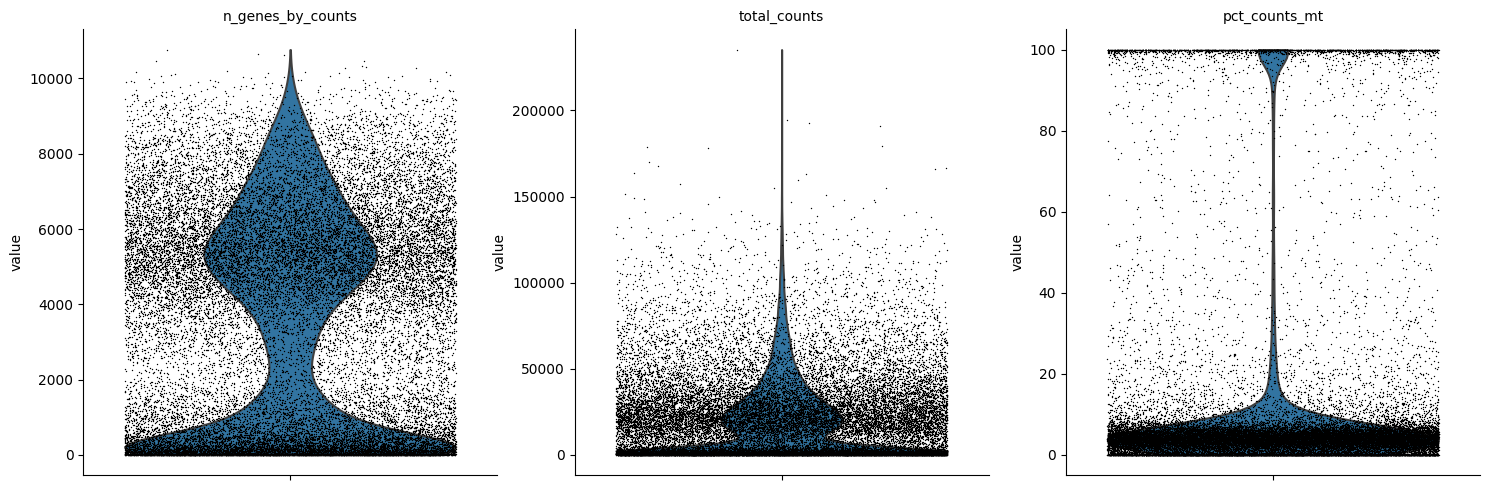

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
#graphing number of counts, pct mt and genes
# NOTE: n_genes_by_counts translates to the number of genes with at least one count in that cell
#multi panel so each has its own y axis

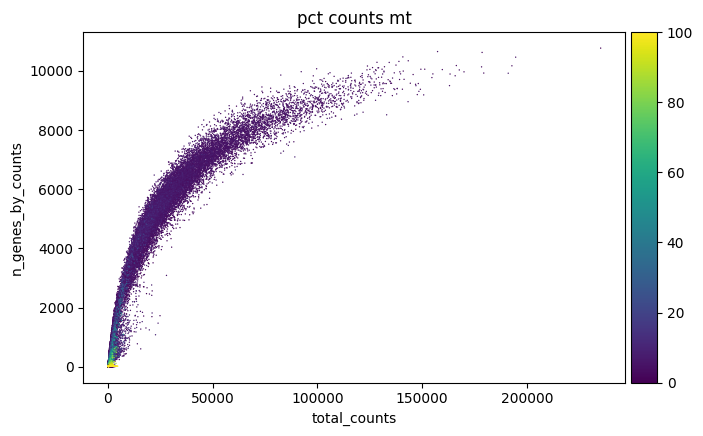

In [6]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", )

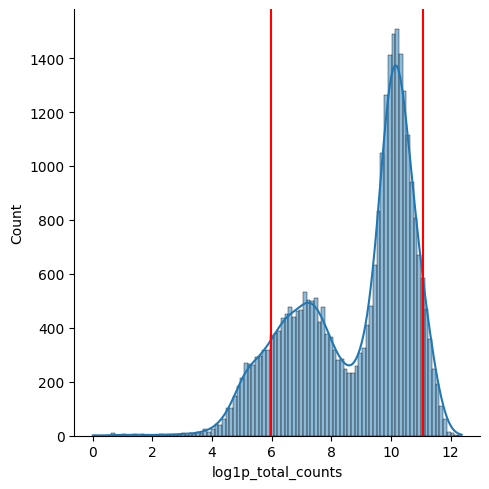

In [7]:
counts_lower=2.5
counts_upper=2
p1 = sns.displot(adata.obs["log1p_total_counts"], bins=100, kde=True)
plt.axvline(np.mean(adata.obs["log1p_total_counts"])-counts_lower*median_abs_deviation(adata.obs["log1p_total_counts"]),  color="red")
plt.axvline(np.mean(adata.obs["log1p_total_counts"])+counts_upper*median_abs_deviation(adata.obs["log1p_total_counts"]), color="red")

#Plotting cutoffs with 2 median absolute reviation cuttoffs

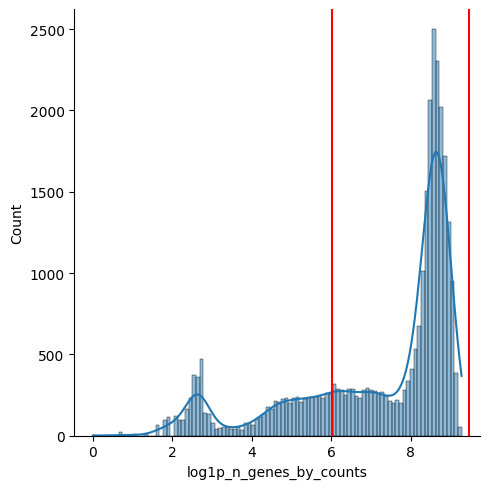

In [10]:
genes_lower=4
genes_upper=2

p2 = sns.displot(adata.obs["log1p_n_genes_by_counts"], bins=100, kde=True)
plt.axvline(np.median(adata.obs["log1p_n_genes_by_counts"])-genes_lower*median_abs_deviation(adata.obs["log1p_n_genes_by_counts"]),  color="red")
plt.axvline(np.median(adata.obs["log1p_n_genes_by_counts"])+genes_upper*median_abs_deviation(adata.obs["log1p_n_genes_by_counts"]), color="red")

#Plotting cutoffs with 2 median absolute deviation cuttoffs

$\text{MAD}=\text{Median}(|X_i-\tilde{X}|)$

In [11]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", upper=counts_upper, lower=counts_lower) | is_outlier(adata, "log1p_n_genes_by_counts", upper=genes_upper, lower=genes_lower))
adata.obs.outlier.value_counts()

False    22746
True      7742
Name: outlier, dtype: int64

In [12]:
adata.obs["mt_outlier"] = ( adata.obs["pct_counts_mt"] > 8)
adata.obs.mt_outlier.value_counts()

False    25273
True      5215
Name: mt_outlier, dtype: int64

In [13]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 30488
Number of cells after filtering of low quality cells: 21143


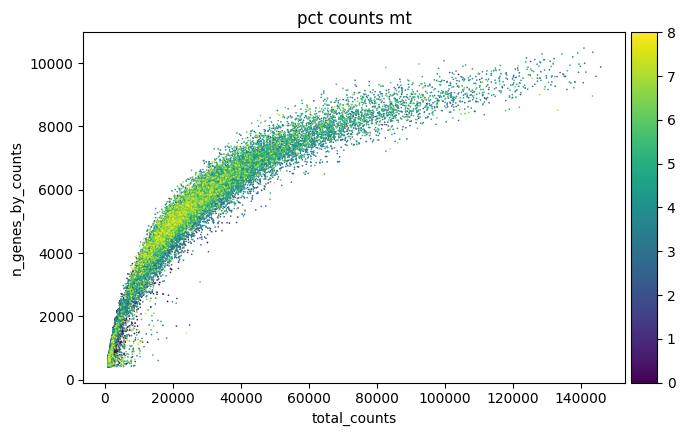

In [14]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [15]:
from ipylab import JupyterFrontEnd

app = JupyterFrontEnd()
app.commands.execute('docmanager:save')
#saving so html writes properly

In [16]:
adata.write_h5ad("qc_filtered.h5ad")
os.system('jupyter nbconvert --to html QC.ipynb')

[NbConvertApp] Converting notebook QC.ipynb to html
[NbConvertApp] Writing 1166800 bytes to QC.html


0